In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [20]:
#Загрузим тренировочную выборку датасета MNIST
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
)

In [21]:
#Загрузим тестовую выборку датасета MNIST
mnist_test = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
)

In [22]:
# Преобразуем изображения в формат NumPy
X_train = mnist_train.data.numpy()  # Преобразуем в массив NumPy
X_test = mnist_test.data.numpy()

# Нормализуем данные, приводя значения к диапазону [0, 1]
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

#переведем таргеты в Numpy
y_train = mnist_train.targets.numpy()
y_test = mnist_test.targets.numpy()

In [23]:
#Проверим размерность загруженных данных 
print(f"Количество объектов в train = {len(X_train_normalized)}")
print(f"Количество объектов в test = {len(X_test_normalized)}")
print(f"Размер изображения = {mnist_train.data.size()[1:]}")

Количество объектов в train = 60000
Количество объектов в test = 10000
Размер изображения = torch.Size([28, 28])


Примеры изображений и меток для тренировочной выборки:


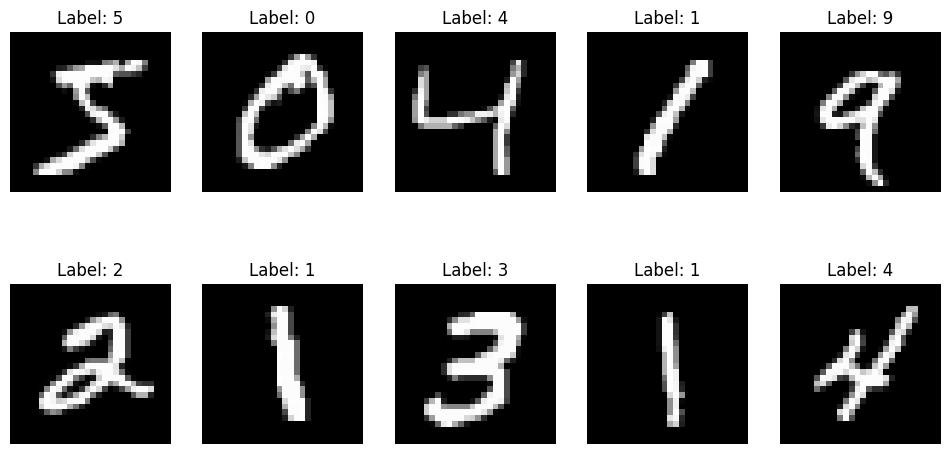

Примеры изображений и меток для тестовой выборки:


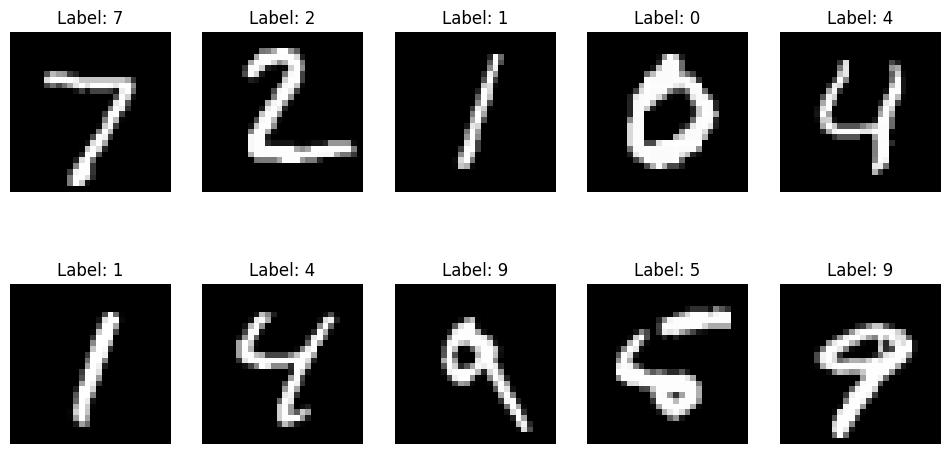

In [24]:
# Пример отображения нескольких изображений и их меток
def display_sample_images(X, y, num_images=8):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        image = X[i].reshape(28, 28)  # Преобразуем одномерный вектор обратно в изображение 28x28
        label = y[i]  # Метка класса
        
        plt.subplot(2, int(num_images/2), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()


#Покажем несколько изображений с метками из тренировочной выборки
print("Примеры изображений и меток для тренировочной выборки:")
display_sample_images(X_train_normalized, y_train, num_images=10)
print("Примеры изображений и меток для тестовой выборки:")
display_sample_images(X_test_normalized, y_test, num_images=10)

In [25]:
# Вытянем матрицу пикселей 28x28 в строку 1x784, для полносвязных слоев
X_train_flattened = X_train_normalized.reshape(-1, 28*28)
X_test_flattened = X_test_normalized.reshape(-1, 28*28)

len(X_train_flattened[0]), len(X_test_flattened[0])

(784, 784)

In [26]:
# Преобразуем таргеты в one-hot вектора, для кросс-энтропии 
one_hot_train = pd.get_dummies(y_train)
y_train_one_hot= one_hot_train.to_numpy().astype(int)

one_hot_test = pd.get_dummies(y_test)
y_test_one_hot = one_hot_test.to_numpy().astype(int)


In [27]:
print(f"Количество получившихся таргетных значений на train = {len(y_train_one_hot)}")
print(f"Количество элементов в one-hot векторах на train = {len(y_train_one_hot[0])}")
print(f"Сравнение исходного таргетного значения с получившимся вектором на train:")
print(f"Исходное значение = {y_train[0]}")
print(f"Получившийся вектор =  {y_train_one_hot[0]}")
print("////////////////////////////////////////////////////////////////////////////////")      
print(f"Количество получившихся таргетных значений на test = {len(y_test_one_hot)}")
print(f"Количество элементов в one-hot векторах на test = {len(y_test_one_hot[0])}")
print(f"Сравнение исходного таргетного значения с получившимся вектором на test:")
print(f"Исходное значение = {y_test[0]}")
print(f"Получившийся вектор =  {y_test_one_hot[0]}")

Количество получившихся таргетных значений на train = 60000
Количество элементов в one-hot векторах на train = 10
Сравнение исходного таргетного значения с получившимся вектором на train:
Исходное значение = 5
Получившийся вектор =  [0 0 0 0 0 1 0 0 0 0]
////////////////////////////////////////////////////////////////////////////////
Количество получившихся таргетных значений на test = 10000
Количество элементов в one-hot векторах на test = 10
Сравнение исходного таргетного значения с получившимся вектором на test:
Исходное значение = 7
Получившийся вектор =  [0 0 0 0 0 0 0 1 0 0]


In [28]:
X_train_flattened

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
# Гиперпараметры сети
input_size = 28 * 28  # Размер входного слоя
hidden_size = 300     # Количество нейронов в скрытом слое
output_size = 10      # Количество классов (10 цифр)
learning_rate = 0.1   # Скорость обучения

# Инициализация весов случайными значениями
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
b2 = np.zeros((1, output_size))

# Функция ReLU и её производная
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Функция softmax
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Функция кросс-энтропии
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

# Функция для вычисления точности
def accuracy(y_true, y_pred):
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    return np.mean(y_true_labels == y_pred_labels)


In [30]:
def forward(X):
    # Прямое распространение
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def backward(X, y_true, z1, a1, z2, a2):
    # Обратное распространение ошибки
    m = X.shape[0]

    dz2 = a2 - y_true  # Ошибка на выходе Вместо кросс-энтропии
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m
    
    dz1 = np.dot(dz2, W2.T) * relu_derivative(z1)  # Ошибка на скрытом слое
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m
    
    return dW1, db1, dW2, db2

def update_weights(dW1, db1, dW2, db2, learning_rate):
    global W1, b1, W2, b2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2


In [31]:
# Параметры обучения
epochs = 20
batch_size = 64
X_train = X_train_flattened.copy()
y_train = y_train_one_hot.copy()

# Начало обучения
for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]
    
    total_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]
        
        # Прямое распространение
        z1, a1, z2, a2 = forward(X_batch)
        
        # Вычисление ошибки
        loss = cross_entropy_loss(y_batch, a2)
        total_loss += loss
        
        # Обратное распространение ошибки
        dW1, db1, dW2, db2 = backward(X_batch, y_batch, z1, a1, z2, a2)
        
        # Обновление весов
        update_weights(dW1, db1, dW2, db2, learning_rate)
    
    # Вывод ошибки и точности после каждой эпохи
    z1, a1, z2, a2 = forward(X_train)
    train_accuracy = accuracy(y_train, a2)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {train_accuracy:.4f}')


Epoch 1/20, Loss: 337.5556, Accuracy: 0.9359
Epoch 2/20, Loss: 176.9598, Accuracy: 0.9572
Epoch 3/20, Loss: 130.6316, Accuracy: 0.9678
Epoch 4/20, Loss: 104.3237, Accuracy: 0.9743
Epoch 5/20, Loss: 86.7318, Accuracy: 0.9760
Epoch 6/20, Loss: 74.3615, Accuracy: 0.9816
Epoch 7/20, Loss: 64.5950, Accuracy: 0.9839
Epoch 8/20, Loss: 56.6035, Accuracy: 0.9861
Epoch 9/20, Loss: 50.3650, Accuracy: 0.9883
Epoch 10/20, Loss: 45.0642, Accuracy: 0.9892
Epoch 11/20, Loss: 40.1605, Accuracy: 0.9913
Epoch 12/20, Loss: 36.5517, Accuracy: 0.9915
Epoch 13/20, Loss: 32.8287, Accuracy: 0.9938
Epoch 14/20, Loss: 29.8048, Accuracy: 0.9947
Epoch 15/20, Loss: 27.0324, Accuracy: 0.9945
Epoch 16/20, Loss: 24.7271, Accuracy: 0.9960
Epoch 17/20, Loss: 22.5798, Accuracy: 0.9966
Epoch 18/20, Loss: 20.7115, Accuracy: 0.9971
Epoch 19/20, Loss: 19.0012, Accuracy: 0.9968
Epoch 20/20, Loss: 17.4763, Accuracy: 0.9975


In [32]:
# Тестирование на тестовых данных
X_test = X_test_flattened.copy()
y_test = y_test_one_hot.copy()
z1, a1, z2, a2 = forward(X_test)
test_accuracy = accuracy(y_test, a2)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.9803
